# Notebook to compare predictions from different formation channels


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from scipy.integrate import quad

# Use latex for text rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #ignore divide by zero warnings

### Load the data 

First the results from this work

Next results from different papers, extracted using WebPlotDigitizer, 

including: 
- Globular cluster results [Antonini et al 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.522..466A)
- POP III star results []()


In [7]:
##########################################
# Results from this work:
# marginals inferred from the LIGO/Virgo data (= observed)
Results_this_work = h5py.File('../../m1m2_cut/data/Astro_Compare_Feature_m1m2.h5', 'r')

# M1 data
observed_m1 = h5py.File('../data/Marginal_m1.h5', 'r')
observed_m1_cutMc = h5py.File('../data/Marginal_m1_cutMc.h5', 'r')

# q distribution
observed_q = h5py.File('../data/marginal_q_data.h5', 'r')
observed_q_cutMc = h5py.File('../data/marginal_q_data_cutMc.h5', 'r')

# chi_effective distribution
observed_chi_eff = h5py.File('../data/marginal_chieff_data.h5', 'r')
observed_chi_eff_cutMc = h5py.File('../data/marginal_chieff_data_cutMc.h5', 'r')
# print(observed_chi_eff_cutMc.keys()) # Note that y-values are m dR/dm


##############
# PPISN: Hendriks et al 2023
Hendriks23 = pd.read_csv('../data/results_from_other_studies/Hendriks23_m1.csv', header=1)
Hendriks23 = Hendriks23.rename(columns={ 'X': 'M1', 'Y': 'dR_dm'})

##############
# Globular clusters: Antonini et al 2023
Antonini23 = pd.read_csv('../data/results_from_other_studies/Antonini23.csv', header=1)
# display(Antonini23)

antonini23_excl_hierarchical = Antonini23[['M1','logdR_dm','q','logdR_dq']]
antonini23_incl_hierarchical = Antonini23[['M1.1','logdR_dm.1','q.1','logdR_dq.1']]

##############
# POP III stars: Kinugawa et al 2021
# M1 masses
Kinugawa21_m1 = pd.read_csv('../data/results_from_other_studies/Kinugawa21_m1.csv', header=1)
Kinugawa21_m1 = Kinugawa21_m1.rename(columns={ 'X': 'M1', 'Y': 'dR_dm'})

# Chieff
Kinugawa21_chi_eff = pd.read_csv('../data/results_from_other_studies/Kinugawa21_chieff.csv', header=1)
Kinugawa21_chi_eff = Kinugawa21_chi_eff.rename(columns={'X': 'chi_eff', 'Y': 'dD_dchi_eff'})


##############
# Pure CHE 
deSa25_m1 =  pd.read_csv('../data/results_from_other_studies/deSa25_che_m1_rates_05z.csv', header = None).T # for z< 0.5
display(deSa25_m1)# deSa25[0] = M1, deSa25[1] = dR/dM1
# 
##############
# Stable mass transfer & CHE
# M1 masses
Briel23 = pd.read_csv('../data/results_from_other_studies/Briel_2023.csv', header=1)
Briel23 = Briel23.rename(columns={ 'X': 'M1', 'Y': 'dR_dm'})
Briel23 = Briel23.rename(columns={ 'X.1': 'qBH', 'Y.1': 'dR_dqBH'})



,0,1
0,9.0,6.274814e-03
1,9.1,6.356179e-03
2,9.2,6.442465e-03
3,9.3,6.533780e-03
4,9.4,6.630230e-03
...,...,...
1105,119.5,1.209068e-06
1106,119.6,1.125059e-06
1107,119.7,1.046633e-06
1108,119.8,9.734367e-07


In [8]:
print(Results_this_work.keys())


<KeysViewHDF5 ['R50_chi_eff', 'R50_m1', 'R50_q', 'R50_z', 'R5_chi_eff', 'R5_m1', 'R5_q', 'R5_z', 'R95_chi_eff', 'R95_m1', 'R95_q', 'R95_z', 'chi_eff', 'm1', 'q', 'z']>


In [9]:
def rescale_rate_binned(R_avg, z1, z2, Lambda = 3.4):
    '''
    Rescale rate for binned values (i.e. 0 <z < 0.5)
    Lambda = 3.4 from results of this work
    <R> = R0 *  1/(z2 - z1) \int_z1^z2 (1 + z)^Lambda
        = R0 * scale_const
    '''
    # integrand = lambda z: (1 + z)**Lambda
    # integral, _ = quad(integrand, z1, z2)
    if Lambda != -1:
        integral = ((1 + z2)**(Lambda + 1) - (1 + z1)**(Lambda + 1)) / (Lambda + 1)  
    else:
        integral = np.log((1 + z2)/(1 + z1)) 
    scale_const = integral / (z2 - z1)
    return R_avg/scale_const # R0 = <R>/scale_const

def rescale_rate_unbinned(R_at_z, z, Lambda = 3.4):
    '''
    assuming R0 = R(z) / (1 + z)^Lambda
    using Lambda = 3.4 from results of this work
    '''
    return R_at_z/(1+ z) ** Lambda

## Primary mass comparison

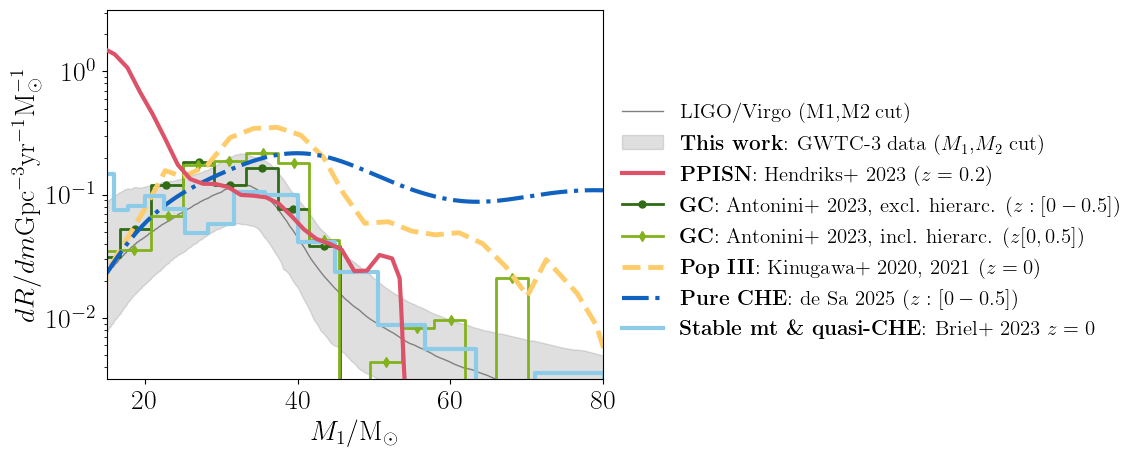

In [69]:
###########
# GW data (observed)
plt.plot(observed_m1['m1'][()], Results_this_work['R50_m1'][()]/Results_this_work['m1'][()],
         label='LIGO/Virgo (M1,M2 cut)', color='grey', lw=1)
plt.fill_between( Results_this_work['m1'][()], 
                Results_this_work['R5_m1'][()]/Results_this_work['m1'][()], 
                Results_this_work['R95_m1'][()]/Results_this_work['m1'][()],
                alpha=0.25, color='grey', label=r'\textbf{This work}: GWTC-3 data ($M_1$,$M_2$ cut)')

# # with Mchirp cut
# # plt.plot(observed_m1_cutMc['m1'][()], np.log10(observed_m1_cutMc['y50'][()]/observed_m1_cutMc['m1'][()]),
#         #  label='LIGO/Virgo (Mchirp cut)', color='grey', lw=3)
# plt.fill_between( observed_m1_cutMc['m1'][()], 
#                 np.log10(observed_m1_cutMc['y10'][()]/observed_m1_cutMc['m1'][()]), 
#                 np.log10(observed_m1_cutMc['y90'][()]/observed_m1_cutMc['m1'][()]),
#                 alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (Mchirp cut)') # 1A7BB7

varname = ''
###########
# PPISN
plt.plot(Hendriks23['M1'], Hendriks23['dR_dm'],
         label=r'\textbf{PPISN}: Hendriks+ 2023 ($z=0.2$)', color='#DC5268', lw=3, zorder = 10) # blue: #8FC1E1 rust: #D85415 pink: #FF9E7B

###########
# Globular cluster predictions
plt.step(antonini23_excl_hierarchical['M1'], 10**antonini23_excl_hierarchical['logdR_dm'], 
            where = 'mid', label=r'\textbf{GC}: Antonini+ 2023, excl. hierarc. ($z : [0-0.5]$)', 
             lw = 2, color='#306B15', marker ='o', ms = 5) # #374709: dark green

plt.step(antonini23_incl_hierarchical['M1.1'], 10**antonini23_incl_hierarchical['logdR_dm.1'],
         where = 'mid', label=r'\textbf{GC}: Antonini+ 2023, incl. hierarc. ($z [0, 0.5]$)',
          lw = 2, color='#82b21e', marker ='d', ms = 5) # #82b21e: light green


###########
# POP III predictions
plt.plot(Kinugawa21_m1['M1'], Kinugawa21_m1['dR_dm'], 
         label=r'\textbf{Pop III}: Kinugawa+ 2020, 2021 ($z = 0$)', color='#FECC6A', lw=3.5, ls = '--') # yellow: #FECC6A

###########
# Pure CHE
plt.plot(deSa25_m1[0], deSa25_m1[1],
         label=r'\textbf{Pure CHE}: de Sa 2025 ($z : [0-0.5]$)', color='#1162bf', lw=3, ls='-.') # dark blue: 1162bf


###########
# Stable mass transfer & CHE
plt.step(Briel23['M1'], Briel23['dR_dm'],
         where = 'mid', label=r'\textbf{Stable mt \& quasi-CHE}: Briel+ 2023 $z=0$',
          color='#8CCCE9', lw=3) # brown: A65E2E  F63922  pink :#8FC1E1

###########
# plot values
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False) 

plt.xlabel(r'$M_1$/M$_\odot$', fontsize=20)
plt.ylabel(r'$d R/dm \mathrm{Gpc^{-3}yr^{-1} M_{\odot}^{-1} }$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(15,80)
plt.ylim(10**-2.5, 10**0.5)
plt.yscale('log')
""
plt.savefig(f'../figures/Compare_m1_formation{varname}.pdf', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

# Mass distributions rescaled to z = 0

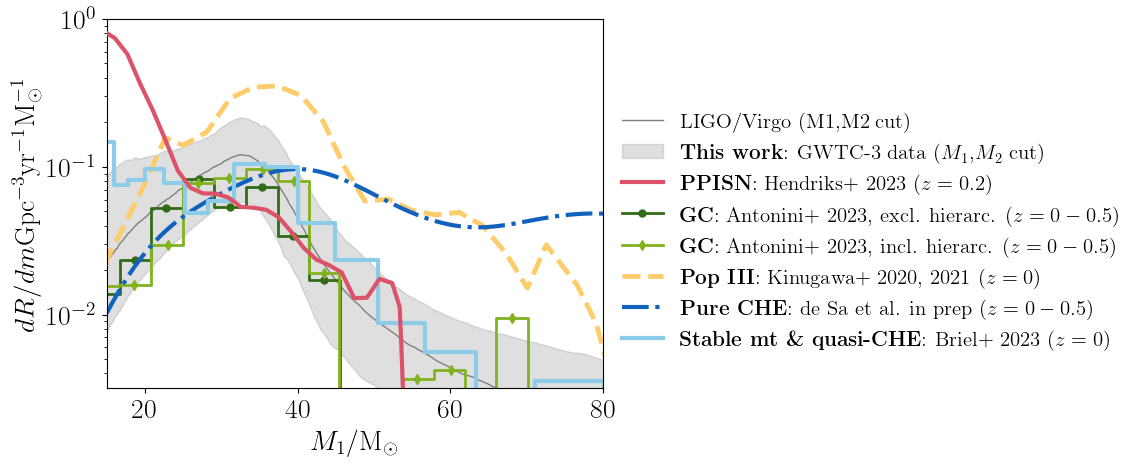

In [ ]:
###########
# GW data (observed)
plt.plot(observed_m1['m1'][()], Results_this_work['R50_m1'][()]/Results_this_work['m1'][()],
         label='LIGO/Virgo (M1,M2 cut)', color='grey', lw=1)
plt.fill_between( Results_this_work['m1'][()], 
                Results_this_work['R5_m1'][()]/Results_this_work['m1'][()], 
                Results_this_work['R95_m1'][()]/Results_this_work['m1'][()],
                alpha=0.25, color='grey', label=r'\textbf{This work}: GWTC-3 data ($M_1$,$M_2$ cut)')

# # with Mchirp cut
# # plt.plot(observed_m1_cutMc['m1'][()], np.log10(observed_m1_cutMc['y50'][()]/observed_m1_cutMc['m1'][()]),
#         #  label='LIGO/Virgo (Mchirp cut)', color='grey', lw=3)
# plt.fill_between( observed_m1_cutMc['m1'][()], 
#                 np.log10(observed_m1_cutMc['y10'][()]/observed_m1_cutMc['m1'][()]), 
#                 np.log10(observed_m1_cutMc['y90'][()]/observed_m1_cutMc['m1'][()]),
#                 alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (Mchirp cut)') # 1A7BB7

varname = '_rescaled'

###########
# PPISN
Hendriks23_rescaled = rescale_rate_unbinned(Hendriks23['dR_dm'], 0.2, Lambda = 3.4) # z = 0.2
plt.plot(Hendriks23['M1'], Hendriks23_rescaled,
         label=r'\textbf{PPISN}: Hendriks+ 2023 ($z=0.2$)', color='#DC5268', lw=3, zorder = 10) # blue: #8FC1E1 rust: #D85415 pink: #FF9E7B

########### 
Antonini_ex_hier_rescaled = rescale_rate_binned(10**antonini23_excl_hierarchical['logdR_dm'], 0, 0.5, Lambda = 3.4)
# Globular cluster predictions 
plt.step(antonini23_excl_hierarchical['M1'], Antonini_ex_hier_rescaled, 
            where = 'mid', label=r'\textbf{GC}: Antonini+ 2023, excl. hierarc. ($z : [0-0.5]$)', 
             lw = 2, color='#306B15', marker ='o', ms = 5) # #374709: dark green

Antonini_incl_hier_rescaled = rescale_rate_binned(10**antonini23_incl_hierarchical['logdR_dm.1'], 0, 0.5, Lambda = 3.4)
plt.step(antonini23_incl_hierarchical['M1.1'], Antonini_incl_hier_rescaled,#10**antonini23_incl_hierarchical['logdR_dm.1'],
         where = 'mid', label=r'\textbf{GC}: Antonini+ 2023, incl. hierarc. ($z : [0-0.5]$)',
          lw = 2, color='#82b21e', marker ='d', ms = 5) # #82b21e: light green


###########
# POP III predictions
plt.plot(Kinugawa21_m1['M1'], Kinugawa21_m1['dR_dm'], 
         label=r'\textbf{Pop III}: Kinugawa+ 2020, 2021 ($z = 0$)', color='#FECC6A', lw=3.5, ls = '--') # yellow: #FECC6A

###########
# Pure CHE (for Zbin between 0 and 0.5)
deSa_rescaled = rescale_rate_binned(deSa25_m1[1], 0, 0.5, Lambda = 3.4)
plt.plot(deSa25_m1[0], deSa_rescaled,
         label=r'\textbf{Pure CHE}: de Sa et al. in prep ($z : [0-0.5]$)', color='#1162bf', lw=3, ls='-.') # dark blue: 1162bf


###########
# Stable mass transfer & CHE
plt.step(Briel23['M1'], Briel23['dR_dm'],
         where = 'mid', label=r'\textbf{Stable mt \& quasi-CHE}: Briel+ 2023 ($z=0$)',
          color='#8CCCE9', lw=3) # brown: A65E2E  F63922  pink :#8FC1E1

###########
# plot values
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False) 

plt.xlabel(r'$M_1$/M$_\odot$', fontsize=20)
plt.ylabel(r'$d R/dm \mathrm{Gpc^{-3}yr^{-1} M_{\odot}^{-1} }$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(15,80)
plt.ylim(10**-2.5, 10**0)
plt.yscale('log')

plt.savefig(f'../figures/Compare_m1_formation{varname}.pdf', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## Mass ratio comparison

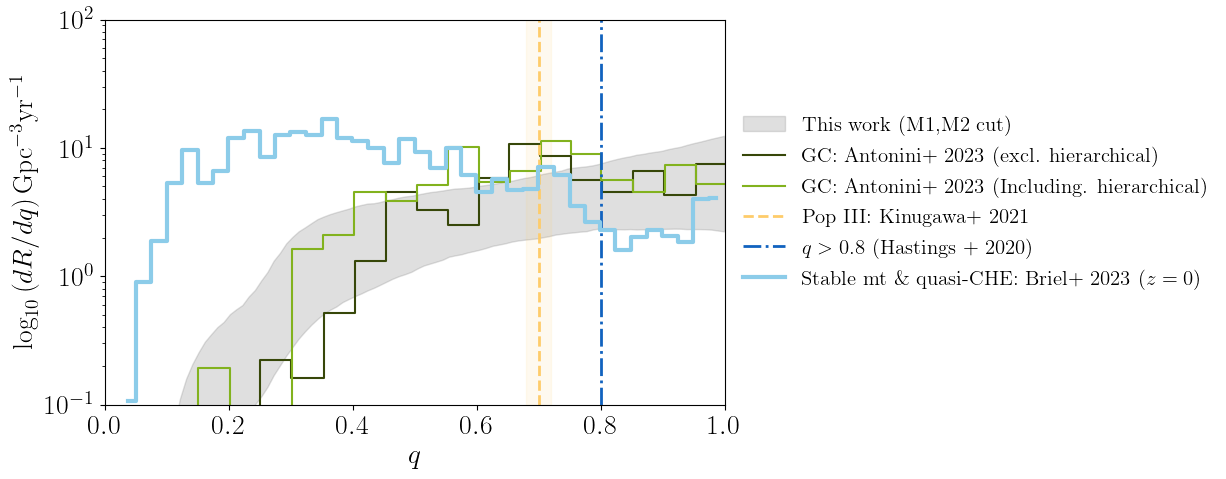

In [60]:
fig, ax = plt.subplots(figsize=(8, 5))



###########
# GW data (observed)
# plt.plot(observed_q['q'][()], np.log10(observed_q['y50'][()]),
#         #  label='LIGO/Virgo (M1,M2 cut)', color='#1A7BB7', lw=3, alpha = 0.9)
plt.fill_between(Results_this_work['q'][()], 
                Results_this_work['R5_q'][()], 
                Results_this_work['R95_q'][()],
                alpha=0.25, color='grey', label='This work (M1,M2 cut)')
# # with Mchirp cut
# # plt.plot(observed_q_cutMc['q'][()], np.log10(observed_q_cutMc['y50'][()]),
#         #  label='LIGO/Virgo (Mchirp cut)', color='grey', lw=3, alpha = 0.9)
# plt.fill_between(observed_q_cutMc['q'][()], 
#                 np.log10(observed_q_cutMc['y10'][()]), 
#                 np.log10(observed_q_cutMc['y90'][()]),
#                 alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (Mchirp cut)')

varname = 'all'

###########
# Globular cluster predictions            
x, y = antonini23_excl_hierarchical['q'].dropna(), antonini23_excl_hierarchical['logdR_dq'].dropna() # drop nans
x, y = np.insert(x, len(x), 1.), np.insert(y, len(y), y.iloc[-1])  # repeat value at the end
plt.step(x, 10**y,
            where = 'mid', label='GC: Antonini+ 2023 (excl. hierarchical)', color='#374709')

x1, y1 = antonini23_incl_hierarchical['q.1'].dropna(), antonini23_incl_hierarchical['logdR_dq.1'].dropna() # drop nans
x1, y1 = np.insert(x1, len(x1), 1.), np.insert(y1, len(y1), y1.iloc[-1])  # repeat value at the end
plt.step(x1, 10**y1,
         where = 'mid', label='GC: Antonini+ 2023 (Including. hierarchical)', color='#82b21e')

###########
# POP III predictions Kinugawa et al 2021,
# Their fig. 4 shows all systems around M1, M2 = 30, have q ~ 0.7 
ax.axvline(x=0.7, color='#FECC6A', lw=2, ls='--', label='Pop III: Kinugawa+ 2021')
plt.fill_between(x=(0.68,0.72), y1=0.1, y2=1000, color='#FECC6A', alpha=0.1)


###########
# Pure CHE
ax.axvline(x=0.8, color='#1162bf', lw=2, ls='-.', label='$q>0.8$ (Hastings + 2020)')
# indicate upper limit
ax.annotate('', xy=(0.85, -0.5),     # arrow head
            xytext=(0.8, -0.5),  # arrow tail
            arrowprops=dict(arrowstyle='->', color='#1162bf', lw=2))

###########
# Stable mass transfer & CHE
ax.step(Briel23['qBH'], Briel23['dR_dqBH'],
         where = 'mid', label='Stable mt \& quasi-CHE: Briel+ 2023 ($z =0$)',
          color='#8CCCE9', lw=3) # brown: A65E2E  F63922  pink :#8FC1E1 

###########
# plot values
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False) 

plt.xlabel(r'$q$', fontsize=20)
plt.ylabel(r'$\log_{10} \left(d R/dq \right) \mathrm{Gpc^{-3}yr^{-1}}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(0,1)
plt.ylim(10**-1, 10**2)
plt.yscale('log')

plt.savefig(f'../figures/Compare_q_formation{varname}.pdf', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

# Mass ratio distribution -- Normalized

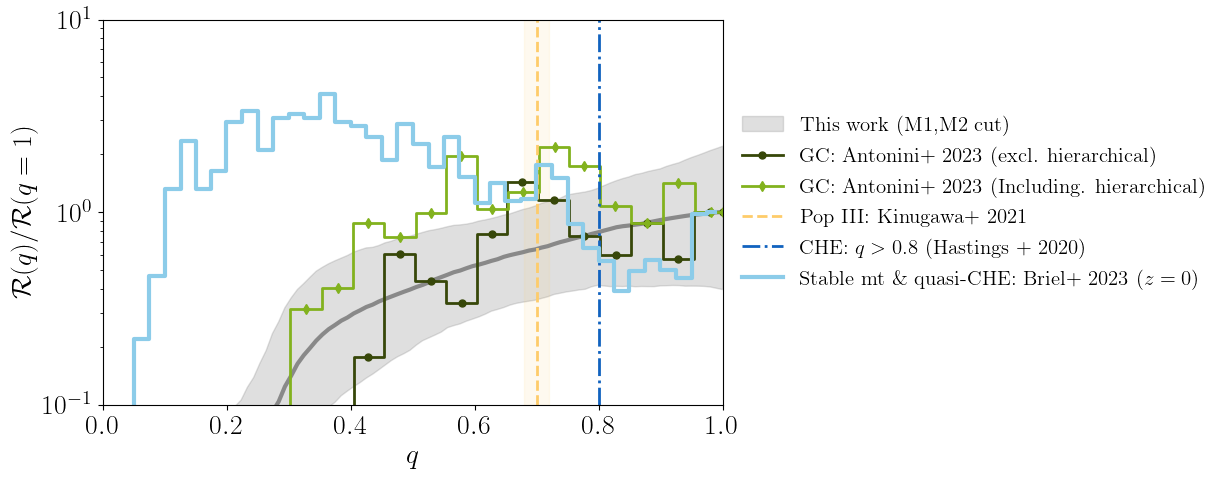

In [61]:
fig, ax = plt.subplots(figsize=(8, 5))

 
###########
# GW data (observed)
observed_q_y50 = Results_this_work['R50_q'][()]
observed_q_y50_norm = observed_q_y50 / observed_q_y50[-1]  # normalize to the last value

observed_q_y10 = Results_this_work['R5_q'][()]
observed_q_y10_norm = observed_q_y10 / observed_q_y50[-1]  # normalize to the last value

observed_q_y90 = Results_this_work['R95_q'][()]
observed_q_y90_norm = observed_q_y90 / observed_q_y50[-1]  # normalize to the last value

plt.plot(Results_this_work['q'][()], observed_q_y50_norm,
         label=None, color='grey', lw=3, alpha = 0.9)
plt.fill_between(Results_this_work['q'][()], 
                observed_q_y10_norm, 
                observed_q_y90_norm,
                alpha=0.25, color='grey', label='This work (M1,M2 cut)')


varname = ''

###########
# Globular cluster predictions            
x, y = antonini23_excl_hierarchical['q'].dropna(), antonini23_excl_hierarchical['logdR_dq'].dropna() # drop nans
x, y = np.insert(x, len(x), 1.), np.insert(y, len(y), y.iloc[-1])  # repeat value at the end
y_normalized = 10**y / 10**y[-1]  # normalize to the highest y-value (y \approx 1, assuming y is strictly assending)
plt.step(x, y_normalized,
            where = 'mid', label='GC: Antonini+ 2023 (excl. hierarchical)',
             color='#374709', lw = 2, marker ='o', ms = 5) # #374709: dark green

x1, y1 = antonini23_incl_hierarchical['q.1'].dropna(), antonini23_incl_hierarchical['logdR_dq.1'].dropna() # drop nans
x1, y1 = np.insert(x1, len(x1), 1.), np.insert(y1, len(y1), y1.iloc[-1])  # repeat value at the end
y1_normalized = 10**y1 / 10**y1[-1]  # normalize to the highest y-value (y \approx 1, assuming y is strictly assending)
plt.step(x1, y1_normalized,
         where = 'mid', label='GC: Antonini+ 2023 (Including. hierarchical)', 
         color='#82b21e', lw = 2, marker ='d', ms = 5) # #82b21e: light green

###########
# POP III predictions Kinugawa et al 2021,
# Their fig. 4 shows all systems around M1, M2 = 30, have q ~ 0.7 
ax.axvline(x=0.7, color='#FECC6A', lw=2, ls='--', label='Pop III: Kinugawa+ 2021')
plt.fill_between(x=(0.68,0.72), y1=0.1, y2=1000, color='#FECC6A', alpha=0.1)


###########
# Pure CHE
ax.axvline(x=0.8, color='#1162bf', lw=2, ls='-.', label='CHE: $q>0.8$ (Hastings + 2020)')
# indicate upper limit
ax.annotate('', xy=(0.85, -0.5),     # arrow head
            xytext=(0.8, -0.5),  # arrow tail
            arrowprops=dict(arrowstyle='->', color='#1162bf', lw=2))

###########
# Stable mass transfer & CHE
Briel_norm = Briel23['dR_dqBH'] / Briel23['dR_dqBH'].iloc[-1]  # normalize to the last value (~q = 1)
ax.step(Briel23['qBH'], Briel_norm,
         where = 'mid', label='Stable mt \& quasi-CHE: Briel+ 2023 ($z =0$)',
          color='#8CCCE9', lw=3) # brown: A65E2E  F63922  pink :#8FC1E1 

###########
# plot values
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False) 

plt.xlabel(r'$q$', fontsize=20)
plt.ylabel(r'$\mathcal{R}(q)/\mathcal{R}(q = 1)$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(0,1)
plt.ylim(10**-1, 10)
plt.yscale('log')

plt.savefig(f'../figures/Compare_q_formation{varname}.pdf', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

# Spins ($\chi_{eff}$)

Because there are no clear simulated predictions in the literature, we resort to analytical expectations

In [62]:
observed_chi_eff_y50 = observed_chi_eff['y50'][()]
print(observed_chi_eff_y50.shape)

print()

(201,)



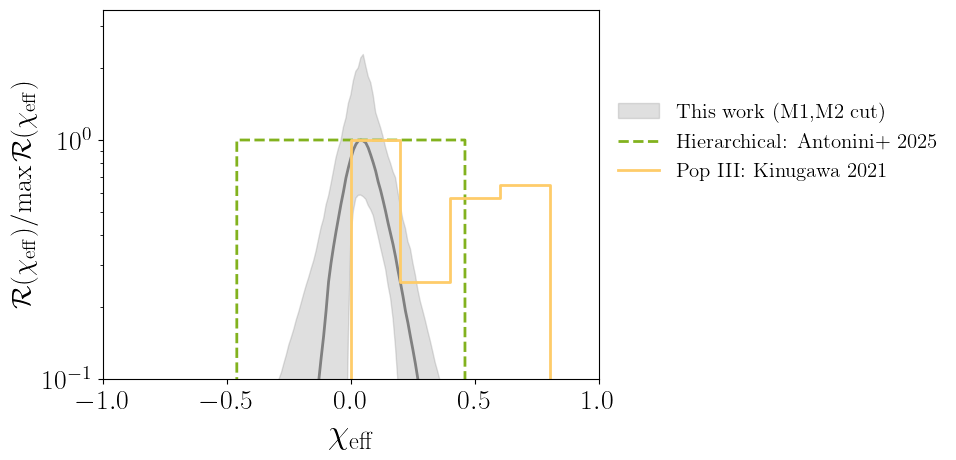

In [63]:
###########
# GW data (observed)
observed_chi_eff_y50 = Results_this_work['R50_chi_eff'][()]
observed_chi_eff_norm =  Results_this_work['R50_chi_eff'][()]/max(observed_chi_eff_y50)  # normalize to the peak value
plt.plot(Results_this_work['chi_eff'][()], observed_chi_eff_norm,
         label=None, color='grey', lw=2)

plt.fill_between(Results_this_work['chi_eff'][()], 
                Results_this_work['R5_chi_eff'][()]/max(observed_chi_eff_y50), 
                Results_this_work['R95_chi_eff'][()]/max(observed_chi_eff_y50),
                alpha=0.25, color='grey', label='This work (M1,M2 cut)')
# with Mchirp cut
# plt.plot(observed_chi_eff_cutMc['chi_eff'][()], np.log10(observed_chi_eff_cutMc['y50'][()]),
        #  label='LIGO/Virgo (Mchirp cut)', color='grey', lw=2)
# plt.fill_between(observed_chi_eff_cutMc['chi_eff'][()], 
#                 np.log10(observed_chi_eff_cutMc['y10'][()]), 
#                 np.log10(observed_chi_eff_cutMc['y90'][()]),
#                 alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (Mchirp cut)')


varname = '_norm'

###########
# Globular cluster predictions            #
# Analytical model from Antonini 2025 (https://ui.adsabs.harvard.edu/abs/2025PhRvL.134a1401A)
# Their equation 1 
x_chieff = np.linspace(-0.69/1.5, 0.69/1.5, 100)
y_chieff = np.full(len(x_chieff), 0.75/0.69)

# prepend and postpend small values to make it a step function
x_chieff, y_chieff = np.insert(x_chieff, 0, -0.70/1.5), np.insert(y_chieff, 0, -5)
x_chieff, y_chieff = np.insert(x_chieff, len(x_chieff), 0.70/1.5), np.insert(y_chieff, len(y_chieff), -5)

Y_normalized = y_chieff / y_chieff[1]  # normalize to value at chi_eff = 0
plt.plot(x_chieff, Y_normalized, ls = '--', color = '#82b21e', lw=2, label='Hierarchical: Antonini+ 2025')

###########
# Kinugawa 2021
# insert very small value at beginning  to complete the step function
x, y = np.insert(Kinugawa21_chi_eff['chi_eff'], 0, -0.1), np.insert(np.log10(Kinugawa21_chi_eff['dD_dchi_eff']), 0, -5)  
x, y = np.insert(x, len(x), 1.1), np.insert(y, len(y), -5)  # insert very small value at end
y_normalized = y / y[1]  # normalize to value at chi_eff = 0
plt.step(x, y_normalized, 
         where = 'mid', label='Pop III: Kinugawa 2021', color='#FECC6A', lw=2)


###########
# plot values
# plt.vlines(x=0, ymin=-3, ymax=3, color='grey', lw=1, ls='--', zorder = 10)

plt.legend(fontsize=15, bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False) 

plt.xlabel(r'$\chi_{\mathrm{eff}}$', fontsize=25)
plt.ylabel(r'$\mathcal{R}(\chi_{\mathrm{eff}})/\mathrm{max} \, \mathcal{R}(\chi_{\mathrm{eff}})$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(-1,1)
plt.ylim(0.1, 3.5)
plt.yscale('log')

plt.savefig(f'../figures/Compare_chi_eff_formation{varname}.pdf', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

# Now combine all three figures into one


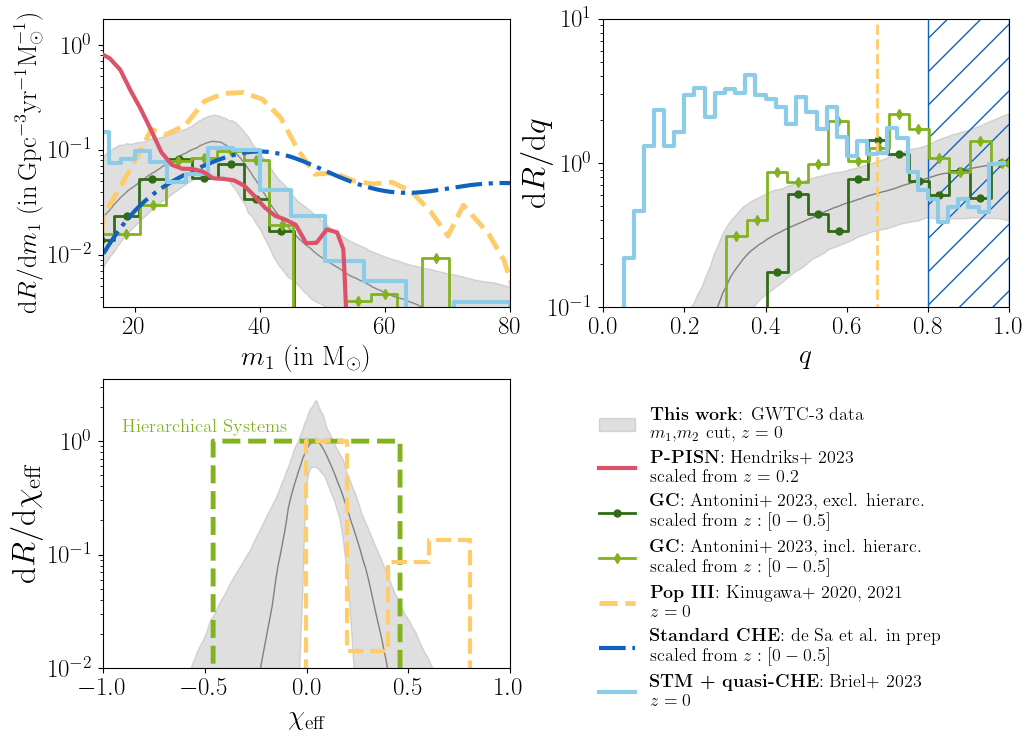

In [85]:
fig, ax = plt.subplots(2, 2, figsize=(10.5, 7.5))

#######################
# Top Left: Mass Plot #
#######################
# GW data (observed, using m1, m2 cut)
ax[0, 0].plot(Results_this_work['m1'][()], Results_this_work['R50_m1'][()]/Results_this_work['m1'][()],
         label=None, color='grey', lw=1, alpha = 0.9)

ax[0, 0].fill_between(Results_this_work['m1'][()], 
                     Results_this_work['R5_m1'][()]/Results_this_work['m1'][()], 
                     Results_this_work['R95_m1'][()]/Results_this_work['m1'][()],
                     alpha=0.25, color='grey', label=r'\textbf{This work}: GWTC-3 data'+'\n'+'$m_1$,$m_2$ cut, $z=0$')
# 
###########
# PPISN
Hendriks23_rescaled = rescale_rate_unbinned(Hendriks23['dR_dm'], 0.2, Lambda = 3.4) # z = 0.2
ax[0, 0].plot(Hendriks23['M1'], Hendriks23_rescaled,
             label=r'\textbf{P-PISN}: Hendriks+ 2023'+'\n'+'scaled from $z=0.2$',  color='#DC5268', lw=3, zorder = 10) # blue: #8FC1E1 rust: #D85415 pink

###########
# Globular clusters
Antonini_ex_hier_rescaled = rescale_rate_binned(10**antonini23_excl_hierarchical['logdR_dm'], 0, 0.5, Lambda = 3.4)
ax[0, 0].step(antonini23_excl_hierarchical['M1'], Antonini_ex_hier_rescaled, 
             where='mid', label=r'\textbf{GC}: Antonini+ 2023, excl. hierarc.'+'\n'+'scaled from $z : [0-0.5]$', 
             lw = 2, color='#306B15', marker ='o', ms = 5) #374709: dark green

Antonini_incl_hier_rescaled = rescale_rate_binned(10**antonini23_incl_hierarchical['logdR_dm.1'], 0, 0.5, Lambda = 3.4)
ax[0, 0].step(antonini23_incl_hierarchical['M1.1'], Antonini_incl_hier_rescaled,
             where='mid', label=r'\textbf{GC}: Antonini+ 2023, incl. hierarc.'+'\n'+'scaled from  $z : [0-0.5]$',
             lw = 2, color='#82b21e', marker ='d', ms = 5) #82b21e: light green


# Repeating hierarchical prediction for legend purposes
# ax[0, 0].plot((-1,-1), (-1,-1), ls='--', color='#82b21e', lw=1.5, label=r'\textbf{Hierarchical}: Antonini+ 2025')

# Pop III
ax[0, 0].plot(Kinugawa21_m1['M1'], Kinugawa21_m1['dR_dm'], 
             label=r'\textbf{Pop III}: Kinugawa+ 2020, 2021'+'\n'+'$z = 0$', 
             color='#FECC6A', lw=3.5, ls = '--') # yellow: #FECC6A

# Pure CHE
deSa_rescaled = rescale_rate_binned(deSa25_m1[1], 0, 0.5, Lambda = 3.4)
ax[0,0].plot(deSa25_m1[0], deSa_rescaled,
         label=r'\textbf{Standard CHE}:  de Sa et al. in prep '+'\n'+'scaled from $z : [0-0.5]$', color='#1162bf', lw=3, ls='-.') # dark blue: 1162bf

# Stable mass transfer & CHE
ax[0, 0].step(Briel23['M1'], Briel23['dR_dm'],
         where = 'mid', label=r'\textbf{STM + quasi-CHE}: Briel+ 2023'+'\n'+'$z=0$',
          color='#8CCCE9', lw=3) # brown: A65E2E  F63922  pink :#8FC1E1 



#############
# Axis styling
ax[0, 0].set_xlabel(r'$m_1~(\mathrm{in~M}_{\odot} )$', fontsize=20)
ax[0, 0].set_ylabel(r'$\mathrm{d}R/\mathrm{d}m_1 ~(\mathrm{in \, Gpc^{-3}yr^{-1} M_{\odot}^{-1})} $', fontsize=19) #
ax[0, 0].tick_params(axis='both', which='major', labelsize=18)
ax[0, 0].set_xlim(15, 80)
ax[0, 0].set_ylim(10**(-2.5), 10**(0.25) )
ax[0, 0].set_yscale('log')  # log scale for y-axis



##################################
# Top Right: Mass Ratio q #
# >> Normalize to q = 1 value <<
##################################
# GW data (observed)
observed_q_y50 = Results_this_work['R50_q'][()]
observed_q_y50_norm = observed_q_y50 / observed_q_y50[-1]  # normalize to the last value
ax[0, 1].plot(Results_this_work['q'][()], observed_q_y50_norm,
              label='LIGO/Virgo (M1,M2 cut)', color='grey', lw=1)

observed_q_y10 = Results_this_work['R5_q'][()]
observed_q_y10_norm = observed_q_y10 / observed_q_y50[-1]  # normalize to the last value

observed_q_y90 = Results_this_work['R95_q'][()]
observed_q_y90_norm = observed_q_y90 / observed_q_y50[-1]  # normalize to the last value

ax[0, 1].fill_between(Results_this_work['q'][()], 
                     observed_q_y10_norm, 
                     observed_q_y90_norm,
                     alpha=0.25, color='grey', label='LIGO/Virgo (M1,M2 cut)')

# Globular clusters
x, y = antonini23_excl_hierarchical['q'].dropna(), antonini23_excl_hierarchical['logdR_dq'].dropna()
 # drop nans
x, y = np.insert(x, len(x), 1.), np.insert(y, len(y), y.iloc[-1])  # repeat value at the end
y_normalized = 10**y / 10**y[-1]  # normalize to the highest y-value (y \approx 1, assuming y is strictly assending)
ax[0, 1].step(x, y_normalized, where='mid', label='GC: Antonini+ 2023 (excl. hierarc.)',
                 color='#306B15', lw=2, marker='o', ms=5) #374709: dark green
             
x1, y1 = antonini23_incl_hierarchical['q.1'].dropna(), antonini23_incl_hierarchical['logdR_dq.1'].dropna() # drop nans
x1, y1 = np.insert(x1, len(x1), 1.), np.insert(y1, len(y1), y1.iloc[-1])  # repeat value at the end
y1_normalized = 10**y1 / 10**y1[-1]  # normalize to the highest y-value (y \approx 1, assuming y is strictly assending)
ax[0, 1].step(x1, y1_normalized, where='mid', label='GC: Antonini+ 2023 (Incl. hierarc.)',
                color='#82b21e', lw=2, marker='d', ms=5) #82b21e: light green

# Pop III
ax[0, 1].axvline(x=0.673, ymin=-3, ymax=3, color='#FECC6A', lw=2, ls='--', label='Pop III: Kinugawa+ 2021')
# ax[0, 1].fill_between(x=(0.68, 0.72), y1=0.01, y2=1000, color='#FECC6A', alpha=0.1)


# Pure CHE
ax[0,1].fill_between(x=(0.8,1), y1=0.01, y2=1000, color = 'none', facecolor='none', alpha=1.,edgecolor='#1162bf', 
                        hatch = '/', label='CHE: $q>0.8$ (Hastings + 2020)')


# Stable mass transfer & CHE
Briel_norm = Briel23['dR_dqBH'] / Briel23['dR_dqBH'].iloc[-1]  # normalize to the last value (~q = 1)
ax[0, 1].step(Briel23['qBH'], Briel_norm,
         where = 'mid', label='Stable mt + quasi-CHE: Briel+ 2023 ($z =0$)',
          color='#8CCCE9', lw=3) # brown: A65E2E  F63922  pink :#8FC1E1 


# Axis styling
ax[0, 1].set_xlabel(r'$q$', fontsize=20)
ax[0, 1].set_ylabel(r'$\mathrm{d}R/\mathrm{d}q$', fontsize=24, labelpad=-3)
ax[0, 1].tick_params(axis='both', which='major', labelsize=18)
ax[0, 1].set_xlim(0, 1)
ax[0, 1].set_ylim(10**-1, 10**1)
ax[0, 1].set_yscale('log')  # log scale for y-axis



##############################
# Bottom Left: chi_eff Plot  #
##############################
# GW data (observed)
observed_chi_eff_y50 = Results_this_work['R50_chi_eff'][()]
observed_chi_eff_norm =  Results_this_work['R50_chi_eff'][()]/max(observed_chi_eff_y50)  # normalize to the peak value
ax[1, 0].plot(Results_this_work['chi_eff'][()], observed_chi_eff_norm,
         label='LIGO/Virgo (M1,M2 cut)', color='grey', lw=1)

ax[1, 0].fill_between(Results_this_work['chi_eff'][()], 
                     Results_this_work['R5_chi_eff'][()]/max(observed_chi_eff_y50), 
                     Results_this_work['R95_chi_eff'][()]/max(observed_chi_eff_y50),
                     alpha=0.25, color='grey', label='LIGO/Virgo (M1,M2 cut)')

# Hierarchical prediction for 2G + 1G 
x_chieff = np.linspace(-0.69/1.5, 0.69/1.5, 100)
y_chieff = np.full(len(x_chieff), 10* 0.75/0.69)
x_chieff, y_chieff = np.insert(x_chieff, 0, -0.70/1.5), np.insert(y_chieff, 0, -5)
x_chieff, y_chieff = np.insert(x_chieff, len(x_chieff), 0.70/1.5), np.insert(y_chieff, len(y_chieff), -5)
Y_normalized = y_chieff / max(y_chieff)  # normalize to peak value
ax[1, 0].plot(x_chieff, Y_normalized, ls='--', color='#82b21e', lw=3.5, label='Hierarchical: Antonini+ 2025')

# Anotate 
ax[1,0].text(-0.5,1.1,'Hierarchical Systems', fontsize=13.5, 
            color='#82b21e', ha='center', va='bottom')


# Pop III
x, y = np.insert(Kinugawa21_chi_eff['chi_eff'], 0, -0.1), np.insert(Kinugawa21_chi_eff['dD_dchi_eff'], 0, -0.1)
x, y = np.insert(x, len(x), 1.1), np.insert(y, len(y), -5)
yPOPIII_normalized = y / max(y)  # normalize to peak value
ax[1, 0].step(x, yPOPIII_normalized, where='mid', label='Pop III: Kinugawa 2020, 2021', color='#FECC6A', ls = '--', lw=3)

# Axis styling
ax[1, 0].set_xlabel(r'$\chi_{\mathrm{eff}}$', fontsize=20)
ax[1, 0].set_ylabel(r'$\mathrm{d}{R}/\mathrm{d}\chi_{\mathrm{eff}} $', fontsize=24)
ax[1, 0].tick_params(axis='both', which='major', labelsize=18)
ax[1, 0].set_xlim(-1, 1)
ax[1, 0].set_ylim(0.01, 3.5)
ax[1, 0].set_yscale('log')



##########################
# Bottom Right: Legend   #
##########################
ax[1, 1].axis('off')  # Turn off the axis
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[1, 1].legend(handles, labels, loc='lower left', fontsize=13, frameon=False, bbox_to_anchor=(-0.05, -0.2))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.23, hspace=0.25)

# Save the combined figure
plt.savefig('../figures/Compare_formation_combined.pdf', bbox_inches='tight', dpi=300, transparent=True)
plt.show()
